### Analysis of the gradient for different $p^-(\theta)$

### Imports

In [1]:
import math
import os
from collections.abc import Callable
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from flowjax.distributions import Normal
from flowjax.experimental.numpyro import sample
from jaxtyping import Array, ArrayLike, Scalar
from softcvi.models import AbstractGuide, AbstractReparameterizedModel

from softcvi_validation import utils

os.chdir(utils.get_abspath_project_root())

from scripts.run_task import get_losses  # noqa: E402

plt.style.use("./plots/style.mplstyle")
palette = utils.get_palette()
negative_distribution = "proposal"
n_particles = 8

### Define the model
We use a toy Gaussian example, matching that from [Glockler, Deistler and Macke, 2022](https://arxiv.org/abs/2203.04176), except we also can scale the dimensionality.


In [2]:
class ToyGaussian(AbstractReparameterizedModel):
    observed_names = {"x"}
    reparameterized: bool | None
    reparam_names = set()
    dim: int
    true_loc = 4/5
    true_log_scale = math.log(jnp.sqrt(4/5))

    def __init__(
            self,
            *,
            dim: int,
            ):
        self.dim = dim
        self.reparameterized = False

    def call_without_reparam(self, obs: dict[str, Scalar] | None = None):
        obs = obs["x"] if obs is not None else None
        theta = sample("theta", Normal(jnp.zeros(self.dim), 2))
        sample("x", Normal(theta, 1), obs=obs)


class ToyGaussianGuide(AbstractGuide):
    """Toy Gaussian guide, parameterized using loc and log_scale. 

    Args:
        loc: Mean parameter.
        log_scale: Log standard deviation.
    """
    normal: Normal

    def __init__(
        self,
        loc: ArrayLike,
        log_scale: ArrayLike,
        ):
        self.normal = Normal(loc, jnp.exp(log_scale))
        
    def __call__(self):
        sample("theta", self.normal)


In [3]:
def get_grads(dim, get_guide: Callable, params: Array, n_keys: int):
    model = ToyGaussian(dim=dim)
    obs = {"x": jnp.ones((dim, ))}

    losses = get_losses(
        obs,
        n_particles=n_particles,
        negative_distribution=negative_distribution,
        )
    losses.pop("ELBO")

    grads = {}

    def _get_grad_fn(loss, params):
        
        @jax.jit
        @partial(jax.vmap, in_axes=[0, None]) # Single seed, several params
        @jax.grad
        def _grad(params, key):  # Single seed, single param
            guide = get_guide(params)
            return loss(*eqx.partition((model, guide), eqx.is_inexact_array), key)
        
        params = jnp.broadcast_to(params[:, None], (params.size, dim))
        # We use map over keys (less memory hungry than vmap)
        return lambda k: jax.lax.map(partial(_grad, params), k)

    for k, loss in losses.items():
        grad_fn = _get_grad_fn(loss=loss, params=params)
        keys = jr.split(jr.PRNGKey(1), n_keys)
        grads[k] = grad_fn(keys) # (n_keys, n_params, dim)
    return grads


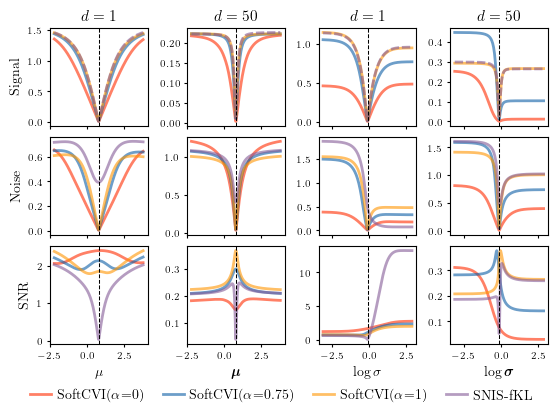

In [5]:
def mu_to_guide(mu):
    return ToyGaussianGuide(mu, ToyGaussian.true_log_scale)

def log_scale_to_guide(log_scale):
    return ToyGaussianGuide(ToyGaussian.true_loc, log_scale)

n_keys = 5000
DIMS = [1, 50]

total_fig = plt.figure(
        figsize=(plt.rcParams["figure.figsize"][0], 4),
        layout="constrained",
        )

fig, legend_fig = total_fig.subfigures(nrows=2, height_ratios=[20,1])
axes = fig.subplots(ncols=2*len(DIMS), nrows=3, sharex="col")



def plot_snr_on_ax(
    get_guide_fn,
    params,
    truth,
    axes,
):
    for i, dim in enumerate(DIMS):
        grads = get_grads(dim, get_guide_fn, params, n_keys=n_keys)
        for k, v in grads.items():
            # Following https://arxiv.org/abs/1802.04537, we compute independently
            # for each dim and then we reduce using the mean.
            label = k.replace("a=", r"$\alpha$=")
            s = 2

            if negative_distribution == "proposal" and k=="SNIS-fKL":
                linestyle = (0, (3, 1))
            else:
                linestyle = "-"

            # Signal
            signal = jnp.abs(jnp.mean(v, axis=0)).mean(axis=-1)

            axes[0, i].plot(
                params,
                signal,
                label=label,
                color=palette[k],
                linewidth=s,
                linestyle=linestyle,
                alpha=0.6,
            )

            # Noise
            noise = jnp.std(v, axis=0).mean(axis=-1)

            axes[1, i].plot(
                params,
                noise,
                label=label,
                color=palette[k],
                linewidth=s,
                alpha=0.6,
            )

            # SNR
            axes[2, i].plot(
                params,
                signal / noise,
                label=label,
                color=palette[k],
                linewidth=s,
                alpha=0.6,
            )

    for ax in axes.ravel():
        ax.axvline(x=truth, color="black", linestyle="dashed", lw=0.75)

    for ax, dim in zip(axes[0], DIMS, strict=True):
        ax.set_title(rf"$d={dim}$")


plot_snr_on_ax(
    mu_to_guide,
    jnp.linspace(ToyGaussian.true_loc-3, ToyGaussian.true_loc+3, 200),
    ToyGaussian.true_loc,
    axes[:, :len(DIMS)],
    )

plot_snr_on_ax(
    log_scale_to_guide,
    jnp.linspace(ToyGaussian.true_log_scale-3, ToyGaussian.true_log_scale+3, 200),
    ToyGaussian.true_log_scale,
    axes[:, len(DIMS):],
)


x_labels = [
     r"$\mu$",
     r"$\boldsymbol{\mu}$",
     r"$\log\sigma$",
     r"$\log\boldsymbol{\sigma}$",
     ]

for ax, xlab in zip(axes[-1], x_labels, strict=True):
    ax.set_xlabel(xlab)

legend_fig.legend(
    *axes[1,0].get_legend_handles_labels(),
    ncols=5,
    )

[ax.set_box_aspect(1) for ax in axes.ravel()]

# Set titles and labels:
axes[0, 0].set_ylabel("Signal")
axes[1, 0].set_ylabel("Noise")
axes[2, 0].set_ylabel("SNR")

total_fig.savefig(
    f"plots/plots/snr_gaussian_k={n_particles}_negative={negative_distribution}.pdf",
    )

